In [57]:
pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

import keras
import tensorflow_hub as hub
import tensorflow_text as text

In [59]:
import pandas as pd
import numpy as np

In [60]:
# setting A
df_train = pd.read_csv('TR_a.csv')
df_train=df_train.rename(columns={"gold_adj": "gold"})

df_dev = pd.read_csv('TD_a.csv')
df_dev=df_dev.rename(columns={"gold_adj": "gold"})

df_test = pd.read_csv('TE_a.csv')
df_test=df_test.rename(columns={"gold_adj": "gold"})

In [61]:
df_train.shape

(3315, 9)

In [62]:
df_train['gold'].value_counts()

y     1347
n     1021
uk     571
py     255
pn     121
Name: gold, dtype: int64

In [63]:
y = pd.get_dummies(df_train.gold, prefix='gold')
y

,gold_n,gold_pn,gold_py,gold_uk,gold_y
0,0,0,0,0,1
1,0,0,0,0,1
2,1,0,0,0,0
3,1,0,0,0,0
4,0,0,0,0,1
...,...,...,...,...,...
3310,0,0,1,0,0
3311,1,0,0,0,0
3312,1,0,0,0,0
3313,0,0,0,1,0


In [64]:
y_dev = pd.get_dummies(df_dev.gold, prefix='gold')
y_dev

,gold_n,gold_pn,gold_py,gold_uk,gold_y
0,0,0,0,0,1
1,0,0,0,0,1
2,0,0,0,0,1
3,1,0,0,0,0
4,0,0,0,0,1
...,...,...,...,...,...
595,1,0,0,0,0
596,0,0,1,0,0
597,0,0,0,1,0
598,0,0,1,0,0


Roberta Init

In [65]:
# Changed to roberta

bert_preprocess = hub.KerasLayer("https://tfhub.dev/jeongukjae/roberta_en_cased_preprocess/1", trainable=True)
bert_encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/roberta_en_cased_L-12_H-768_A-12/1", trainable=True)

In [66]:
# RoBerta layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text') # Textual input layer
preprocessed_text = bert_preprocess(text_input) # The preprocessing of text
outputs = bert_encoder(preprocessed_text) # Encoded o/p

# Neural network layers
# l = tf.keras.layers.Dense(50, activation='sigmoid', name="output")(outputs['pooled_output'])
# l = tf.keras.layers.Dense(6, activation='softmax', name="soft_output")(l)

l = tf.keras.layers.Dense(5, activation='softmax', name="soft_output")(outputs['pooled_output'])

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

ERROR:absl:hub.KerasLayer is trainable but has zero trainable weights.


In [67]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_6 (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [68]:
import keras

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.learning_rate # I use ._decayed_lr method instead of .lr
    return lr


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.01, restore_best_weights=True)

initial_learning_rate = 0.00002
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

lr_metric = get_lr_metric(optimizer)

METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      lr_metric
]

# optimizer.learning_rate.assign(0.00002)
model.compile(optimizer=optimizer,
              loss='CategoricalCrossentropy',
              metrics=METRICS)

In [69]:
model.fit(df_train['Main_tweet'], y, epochs=200, batch_size=16, callbacks=[callback], validation_data=(df_dev['Main_tweet'],y_dev))

Epoch 1/200
208/208 [==============================] - 220s 1s/step - loss: 1.3689 - accuracy: 0.3928 - precision: 0.4530 - recall: 0.0480 - lr: 2.0000e-05 - val_loss: 1.3699 - val_accuracy: 0.4233 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_lr: 2.0000e-05
Epoch 2/200
208/208 [==============================] - 203s 978ms/step - loss: 1.2982 - accuracy: 0.4537 - precision: 0.5839 - recall: 0.1397 - lr: 2.0000e-05 - val_loss: 1.3566 - val_accuracy: 0.4283 - val_precision: 0.4824 - val_recall: 0.2283 - val_lr: 2.0000e-05
Epoch 3/200
208/208 [==============================] - 205s 987ms/step - loss: 1.2067 - accuracy: 0.5116 - precision: 0.6386 - recall: 0.2863 - lr: 2.0000e-05 - val_loss: 1.3463 - val_accuracy: 0.4533 - val_precision: 0.5015 - val_recall: 0.2717 - val_lr: 2.0000e-05
Epoch 4/200
208/208 [==============================] - 204s 982ms/step - loss: 1.1052 - accuracy: 0.5650 - precision: 0.6604 - recall: 0.3906 - lr: 2.0000e-05 - val_loss: 1.3830 - val_accuracy: 

Dev set

In [70]:
y_dev = pd.get_dummies(df_dev.gold, prefix = 'gold')
print(model.evaluate(df_dev['Main_tweet'], y_dev))
y_predicted = model.predict(df_dev['Main_tweet'])

pred_results = tf.cast(tf.equal(y_predicted, tf.reduce_max(y_predicted, axis = 1, keepdims=True)), tf.float32)

pred_results = pd.DataFrame(pred_results.numpy(), columns = ['gold_n', 
                                       'gold_pn',
                                       'gold_py',                     	
                                       'gold_uk',	
                                       'gold_y'])

pred_results.shape
pred_results.to_numpy()
pred_results = [np.where(r==1)[0][0] for r in pred_results.to_numpy()]
pred_results = pd.DataFrame(pred_results, columns=['gold'])

pred_results['gold'] = pred_results['gold'].map({0:'n', 
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

dev_gtruths = [np.where(r==1)[0][0] for r in y_dev.to_numpy()]
dev_gtruths = pd.DataFrame(dev_gtruths, columns=['gold'])

dev_gtruths['gold'] = dev_gtruths['gold'].map({0:'n', 
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

print('DEV')
from sklearn.metrics import classification_report
print(classification_report(y_true = dev_gtruths['gold'], y_pred = pred_results['gold']))

19/19 [==============================] - 9s 495ms/step - loss: 1.3463 - accuracy: 0.4533 - precision: 0.5015 - recall: 0.2717 - lr: 2.0000e-05
[1.3463146686553955, 0.4533333480358124, 0.5015384554862976, 0.27166667580604553, 2.000000313273631e-05]
19/19 [==============================] - 9s 467ms/step
DEV
              precision    recall  f1-score   support

           n       0.41      0.45      0.43       166
          pn       0.00      0.00      0.00        19
          py       0.00      0.00      0.00        61
          uk       0.47      0.17      0.25       113
           y       0.47      0.74      0.58       241

    accuracy                           0.45       600
   macro avg       0.27      0.27      0.25       600
weighted avg       0.39      0.45      0.40       600



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Set

In [71]:
df_test= df_test.rename(columns={"gold_adj": "gold"})
y_test = pd.get_dummies(df_test.gold, prefix = 'gold')
print(model.evaluate(df_test['Main_tweet'], y_test))
y_predicted = model.predict(df_test['Main_tweet'])

pred_results = tf.cast(tf.equal(y_predicted, tf.reduce_max(y_predicted, axis = 1, keepdims=True)), tf.float32)

pred_results = pd.DataFrame(pred_results.numpy(), columns = ['gold_n', 
                                       'gold_pn',
                                       'gold_py',                     	
                                       'gold_uk',	
                                       'gold_y'])

pred_results.shape
pred_results.to_numpy()
pred_results = [np.where(r==1)[0][0] for r in pred_results.to_numpy()]
pred_results = pd.DataFrame(pred_results, columns=['gold'])

pred_results['gold'] = pred_results['gold'].map({0:'n', 
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

test_gtruths = [np.where(r==1)[0][0] for r in y_test.to_numpy()]
test_gtruths = pd.DataFrame(test_gtruths, columns=['gold'])

test_gtruths['gold'] = test_gtruths['gold'].map({0:'n', 
                                                   1:'pn',
                                                   2:'py',
                                                   3:'uk',
                                                   4:'y'})

print('TEST')
from sklearn.metrics import classification_report
print(classification_report(y_true = test_gtruths['gold'], y_pred = pred_results['gold']))

17/17 [==============================] - 8s 463ms/step - loss: 1.3190 - accuracy: 0.4972 - precision: 0.5571 - recall: 0.3055 - lr: 2.0000e-05
[1.3190476894378662, 0.49715369939804077, 0.5570934414863586, 0.30550283193588257, 2.000000313273631e-05]
17/17 [==============================] - 7s 446ms/step
TEST
              precision    recall  f1-score   support

           n       0.52      0.48      0.50       157
          pn       0.00      0.00      0.00        29
          py       0.00      0.00      0.00        49
          uk       0.28      0.14      0.18        80
           y       0.51      0.83      0.63       212

    accuracy                           0.50       527
   macro avg       0.26      0.29      0.26       527
weighted avg       0.40      0.50      0.43       527



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


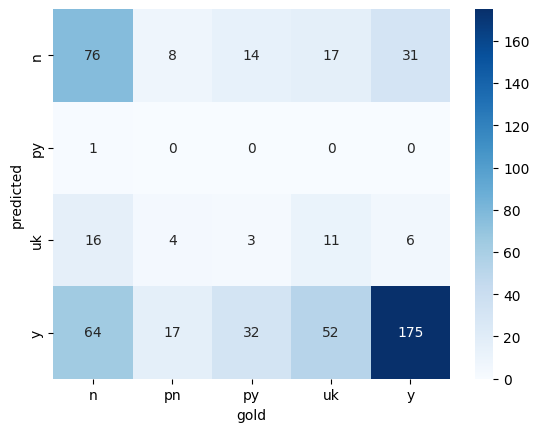

gold        n  pn  py  uk    y
predicted                     
n          76   8  14  17   31
py          1   0   0   0    0
uk         16   4   3  11    6
y          64  17  32  52  175


In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

confusion_matrix = pd.crosstab(pred_results['gold'],test_gtruths['gold'],rownames=['predicted'], colnames=['gold'])

sns.heatmap(confusion_matrix,annot=True,cmap='Blues', fmt='g')
plt.show()
print(confusion_matrix)

In [73]:
pred_results['gold'].value_counts()

y     340
n     146
uk     40
py      1
Name: gold, dtype: int64

In [74]:
pred_results

,gold
0,y
1,y
2,y
3,y
4,y
...,...
522,y
523,y
524,y
525,y


In [75]:
df_test

,Unnamed: 0,Main_Tweet_ID,Reply_id,temporal_setting,Main_tweet,Reply_tweet,gold_1,gold_2,gold
0,0,1505591204783734785,1505605176140472320,new,"Ladies, if a man gives you a Family heirloom r...",depends on why we broke up bc petty match pet...,uk,pn,uk
1,1,1471985146891059206,1471985474621173763,old,I got your back. Do you got mine?,idk but u should cashapp me $plasmanaw,uk,uk,uk
2,2,1465064127399870467,1465229350660284417,old,Is it time to put our combat boots on?,not yet...there will be no choice when they c...,n,n,n
3,3,1524647970611863553,1524648652886757376,new,Do you read the acknowledgments page of a book?,i do - love the little snippets of author’s l...,y,y,y
4,4,1506565419313868802,1506577193626918918,new,"My name regularly gets autocorrected to ""Satan...",i managed to text my french electrician calli...,y,y,y
...,...,...,...,...,...,...,...,...,...
522,522,1532024495308939265,1532030543788916737,new,Do you like rift?,"accidentally clicked no, but i meant to click...",y,y,y
523,523,1471985146891059206,1471985557656031235,old,I got your back. Do you got mine?,"always! i'll even be an alibi, if needed.",y,y,y
524,524,1451009236423565312,1451015270584233985,old,Is it just me but if you listen real hard do y...,i don’t wanna listen that hard.,n,n,n
525,525,1426184209153118214,1426312272079736832,old,Do you think that cosmetic surgery has become ...,yep. it’s hard to get your hands around a goo...,y,y,y


In [76]:
pred_results = pred_results.rename(columns={"gold": "predict"})
pred_results['Main_Tweet_ID'] = df_test['Main_Tweet_ID']
pred_results['Reply_id'] = df_test['Reply_id']


In [77]:
pred_results['predict'].value_counts()

y     340
n     146
uk     40
py      1
Name: predict, dtype: int64

In [78]:
pred_results.to_csv('/content/drive/MyDrive/expts_emnlp23/results/A_twitter_q.csv')